# Preprocessing & Modeling

In [2]:
from fastai.vision.all import *
import shutil
from pathlib import Path
import zipfile

##### Fire up the fastai library
We now transfer control over to the fastai library, passing our raw images into the library. We set the path to the class parent directory "categories" which contains all of the class directories "candy", "chips", "cigarettes", "ice cream", "drinks", and "other".

We pass our image file path as an argument to the fastai <code>get_image_files</code> function 

In [105]:
#get all of the image files in `path`
path = Path('categories')
fns = get_image_files(path)
fns

(#889) [Path('categories/ice cream/27.jpg'),Path('categories/ice cream/1.jpg'),Path('categories/ice cream/75.jpg'),Path('categories/ice cream/5696.jpg'),Path('categories/ice cream/23.jpg'),Path('categories/ice cream/xhv0.jpg'),Path('categories/ice cream/arge.jpg'),Path('categories/ice cream/15.jpg'),Path('categories/ice cream/10.jpg'),Path('categories/ice cream/0.15.png')...]

##### remove broken images 
Fastai includes a "verify_images" function as a courtesy to check for broken or corrupted image files:

In [106]:
#display which images files are corrupted 
failed = verify_images(fns)
failed

(#6) [Path('categories/ice cream/em-2.png'),Path('categories/ice cream/61da.jpg'),Path('categories/ice cream/5.04.png'),Path('categories/ice cream/x779.jpg'),Path('categories/ice cream/o_pk.png'),Path('categories/cigarettes/8678.jpg')]

In [107]:
# remove the corrupted images
failed.map(Path.unlink);

# Model setup and creation
With the DataBlock class, we can setup the DataLoaders, which is how the data gets passed to the model. In PyTorch, neural network models expect tuples of (independent, dependent) variables organized in batches, which is what DataLoaders does. 

In [108]:
#DataBlock is an API for customizing the setup of DataLoaders, a class that holds the PyTorch Datasets objects
cstore = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    #item transform- Randomly select/crop part of the image on each epoch
    #min_scale means to select at least 30% of the original image
    item_tfms=RandomResizedCrop(128, min_scale=0.3))

In [109]:
#pass the path containing the image files to the DataBlock to create DataLoaders
dls = cstore.dataloaders(path)

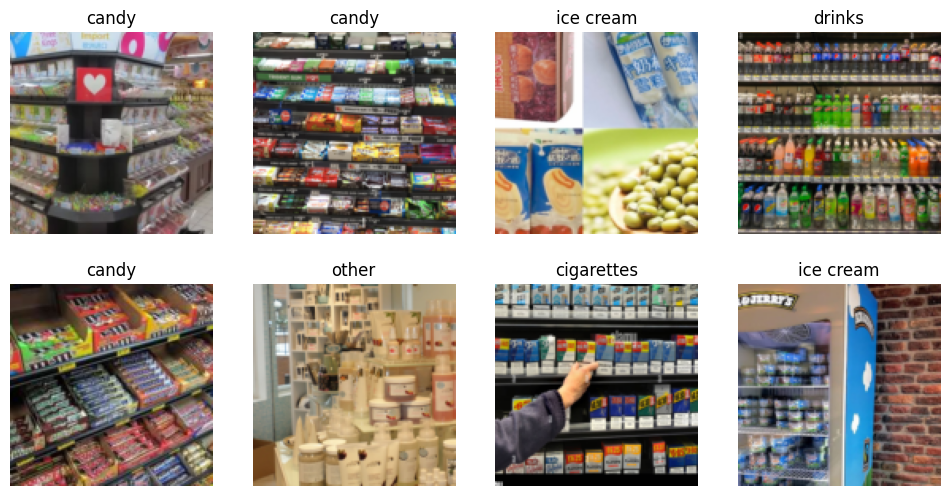

In [112]:
#show a batch of items in the training set
dls.show_batch(max_n=8, nrows=2)

#### Image transfomations applied: RandomResizedCrop:
In this Data Augmentation step, we preview what a single image might look like during a model pass in each epoch. Upon each epoch, "item_tfms=RandomResizedCrop(128, min_scale=0.3) is applied. The image is first rescaled to 128 x 128, and then a portion of the image is cropped out. min_scale=0.3 means that the cropped out portion of the image must be at least 30% in size compared to the original image size. Performing these crops is one of the simplest forms of Data Augmentation. We perform this step because:
1. Items need to be resized anyways - all images come in different sizes and pixel dimenstions, but they must have the same tensor.shape for the model to be able to process them.
2. Cropping out a random portion on each epoch will help the model identify the basic features of the item being classified, and possibly help it to generalize more.

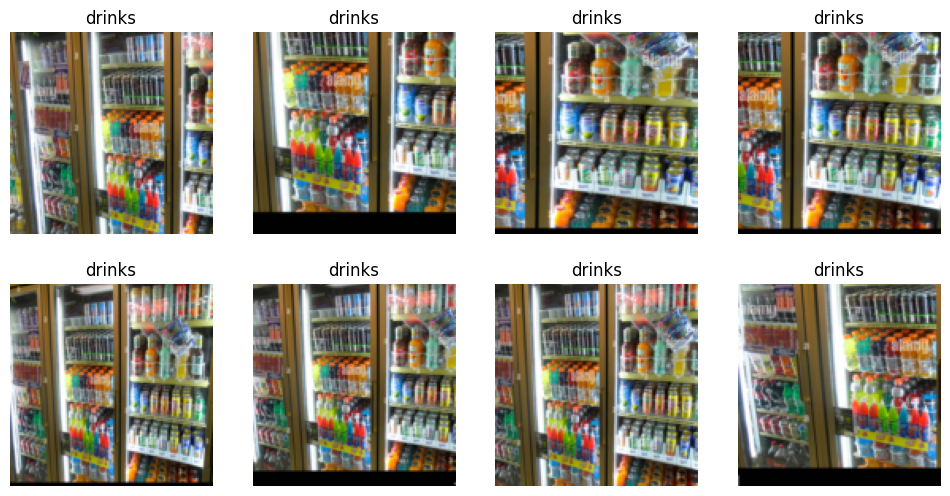

In [113]:
#set unique=True to show how `RandomResizedCrop` is applied to just one item
dls.train.show_batch(max_n=8, nrows=2, unique=True)

#### Image transfomations applied: rotating, flipping, perspective change, brightness, and contrast changes:
Here, data augmentation is applied using the 'aug_transforms' function from fastai. It is a keyword argument under 'batch_tfms', meaning that the GPU will apply these transformations all at once in optimized C. This is made possible because in the previous function argument, "item_tfms" resizes the images in the batch to identical sizes, (128 x 128). Image tensors must be of the same shape before being executed on the GPU for processing.

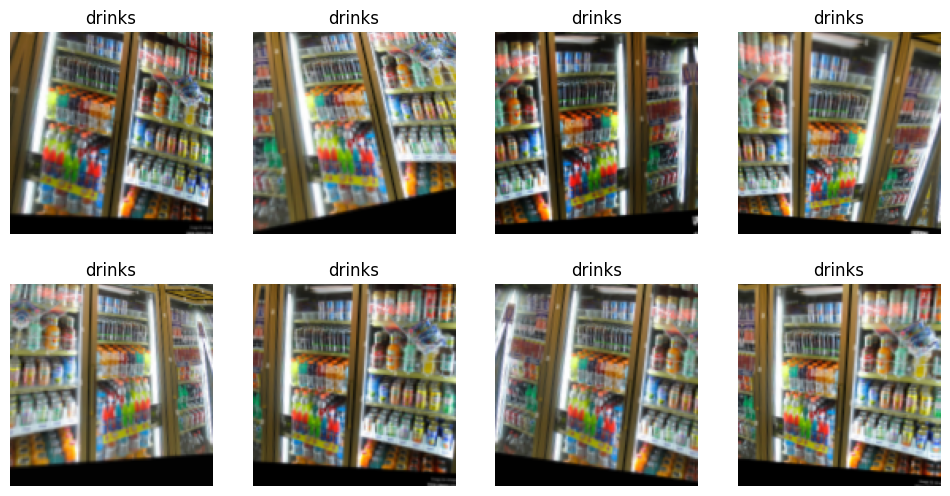

In [114]:
cstore = cstore.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=1))
dls = cstore.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

#### Image Transformations applied twice as much:
Here, we can see in more detail the quality of the types of transformations applied. This is because we set "mult=2", so that the level of image augmentation applied is twice in magnitude.

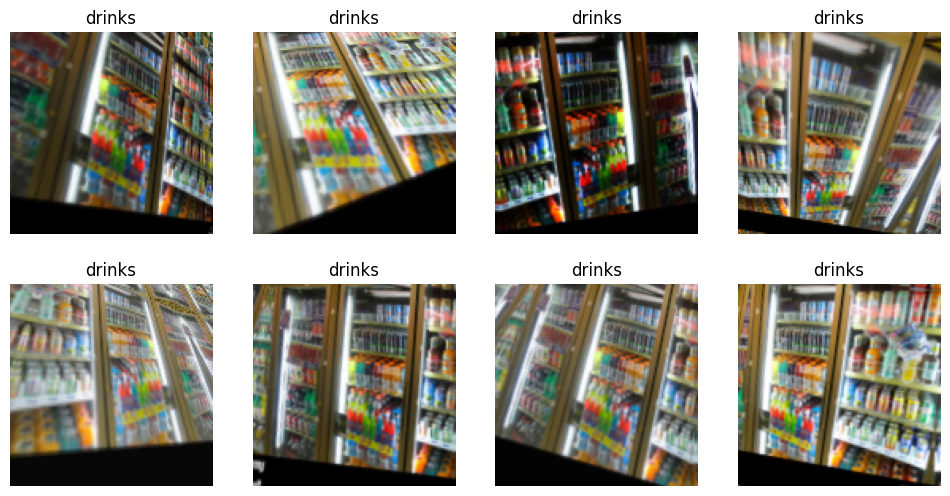

In [115]:
cstore = cstore.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = cstore.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [116]:
cstore = cstore.new(
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.3))
dls = cstore.dataloaders(path)

## Data Augmentation

Providing the model with minor variations of the images can improve model performance by giving it more examples to learn from. Trasformations such as flipping, rotating, perspective warping, and brightness and color contrast changes are applied using the "aug_transforms" function from fastai. The specific transformations are shown in the documentation in next cell.

![img](https://github.com/dennis-francis/Springboard/blob/main/Screen%20Shot%202023-11-09%20at%209.59.07%20AM.png?raw=true)

In [14]:
#view the documentation of the image transformations for data augmentation
??aug_transforms

Signature:
aug_transforms(
    mult: 'float' = 1.0,
    do_flip: 'bool' = True,
    flip_vert: 'bool' = False,
    max_rotate: 'float' = 10.0,
    min_zoom: 'float' = 1.0,
    max_zoom: 'float' = 1.1,
    max_lighting: 'float' = 0.2,
    max_warp: 'float' = 0.2,
    p_affine: 'float' = 0.75,
    p_lighting: 'float' = 0.75,
    xtra_tfms: 'list' = None,
    size: 'int | tuple' = None,
    mode: 'str' = 'bilinear',
    pad_mode='reflection',
    align_corners=True,
    batch=False,
    min_scale=1.0,
)
Source:   
def aug_transforms(
    mult:float=1.0, # Multiplication applying to `max_rotate`,`max_lighting`,`max_warp`
    do_flip:bool=True, # Random flipping
    flip_vert:bool=False, # Flip vertically
    max_rotate:float=10., # Maximum degree of rotation
    min_zoom:float=1., # Minimum zoom 
    max_zoom:float=1.1, # Maximum zoom 
    max_lighting:float=0.2, # Maximum scale of changing brightness 
    max_warp:float=0.2, # Maximum value of changing warp per
    p_affine:float=0.75, # 

In [119]:
learn = vision_learner(dls, resnet18, metrics=[accuracy, F1Score(average='weighted'), Precision(average='weighted'), Recall(average='weighted')])
learn.fine_tune(10)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


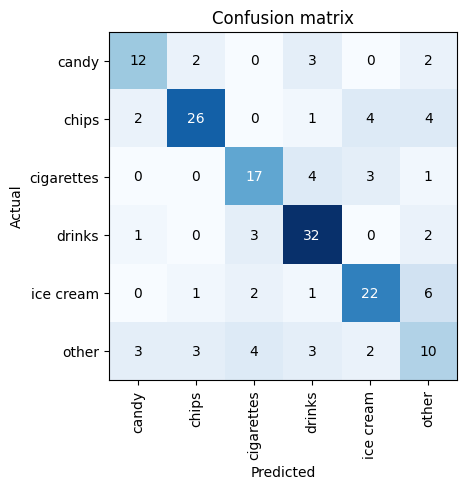

In [120]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Images 2

### Load the images from Google drive
The image dataset is a zip file in google. We can use <code>gdown</code> to grab it.

In [4]:
# install gdown
!pip install gdown -Uqq
!gdown 1L0R4P1UPCkct8Er4FA8o9NolH_XJsPgn

Downloading...
From (uriginal): https://drive.google.com/uc?id=1L0R4P1UPCkct8Er4FA8o9NolH_XJsPgn
From (redirected): https://drive.google.com/uc?id=1L0R4P1UPCkct8Er4FA8o9NolH_XJsPgn&confirm=t&uuid=edb68d4c-c6d8-4da3-b673-535c0408716e
To: /kaggle/working/cstore_images.zip
100%|████████████████████████████████████████| 157M/157M [00:02<00:00, 76.8MB/s]


In [5]:
#unzip the file
with zipfile.ZipFile('/kaggle/working/cstore_images.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working')

In [6]:
# create our path object
path = Path('cstore_images')

#view the labels
path.ls()

(#7) [Path('cstore_images/other'),Path('cstore_images/candy'),Path('cstore_images/Ice cream'),Path('cstore_images/chips'),Path('cstore_images/.DS_Store'),Path('cstore_images/drinks'),Path('cstore_images/cigarettes')]

In [9]:
# remove the unncessary '.DS_Store' directory
Path('cstore_images/.DS_Store').unlink()

In [10]:
path.ls()

(#6) [Path('cstore_images/other'),Path('cstore_images/candy'),Path('cstore_images/Ice cream'),Path('cstore_images/chips'),Path('cstore_images/drinks'),Path('cstore_images/cigarettes')]

##### Check the categories
We define a function called <code>chk_cats()</code> to count the number of images in each category label:

In [7]:
def chk_cats():
    """check the category count. Also check total number of images"""
    count = {
        "candy":0, "chips":0, "cigarettes":0,"drinks":0,"Ice cream":0, "other":0
    }
    tot_img = 0

    for key in count.keys():
        path = Path(f'cstore_images/{key}')
        for photo in path.iterdir():
            count[key] += 1

    for val in count.values():
        tot_img += val

    print(count, tot_img)

In [14]:
chk_cats()

{'candy': 284, 'chips': 128, 'cigarettes': 196, 'drinks': 150, 'Ice cream': 103, 'other': 108} 969


### Run the model

In [16]:
cstore = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.3))

In [17]:
dls = cstore.dataloaders(path)

In [19]:
learn = vision_learner(dls, resnet18, metrics=[accuracy, F1Score(average='weighted'), Precision(average='weighted'), Recall(average='weighted')])
learn.fine_tune(5)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 78.3MB/s]


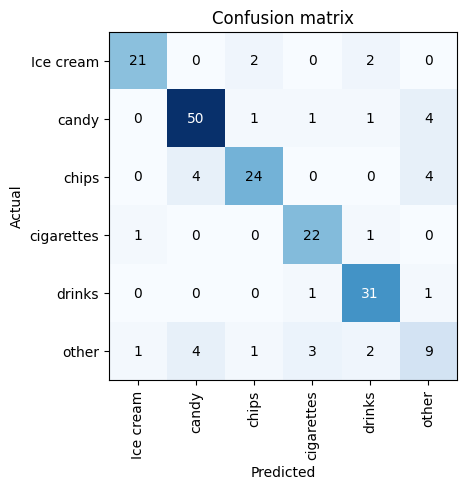

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Images 3

We wrangled with the data some more in the EDA notebook. We balanced the classes that were underrepresented and performed data augmentation. The creator of this notebook also went through the images manually and deleted images that clearly do not make sense for the task and got labeled by mistake.

##### First, we remove the old dataset:
this is just to ensure there are no conflicts when importing the new image dataset:

In [26]:
#we need to remove these
path.ls()

(#6) [Path('cstore_images/other'),Path('cstore_images/candy'),Path('cstore_images/Ice cream'),Path('cstore_images/chips'),Path('cstore_images/drinks'),Path('cstore_images/cigarettes')]

In [28]:
#delete the old dataset:
for cat in path.iterdir():
    for image_file in cat.iterdir():
        image_file.unlink()
    cat.rmdir()

In [29]:
Path('cstore_images').rmdir()
Path('cstore_images.zip').unlink()

##### Import the new dataset

In [30]:
# The data is in a different file in Google drive:
!gdown 1W44htjbuw-IRcgs_WsgDViRBSbAm38rk

Downloading...
From (uriginal): https://drive.google.com/uc?id=1W44htjbuw-IRcgs_WsgDViRBSbAm38rk
From (redirected): https://drive.google.com/uc?id=1W44htjbuw-IRcgs_WsgDViRBSbAm38rk&confirm=t&uuid=3be0aab3-1e44-4c98-98a9-f4834c8b3b64
To: /kaggle/working/cstore_images.zip
100%|█████████████████████████████████████████| 229M/229M [00:01<00:00, 185MB/s]


In [31]:
#unzip the file
with zipfile.ZipFile('/kaggle/working/cstore_images.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working')

In [32]:
# create our path object
path = Path('cstore_images')

#view the labels
path.ls()

(#7) [Path('cstore_images/other'),Path('cstore_images/candy'),Path('cstore_images/Ice cream'),Path('cstore_images/chips'),Path('cstore_images/.DS_Store'),Path('cstore_images/drinks'),Path('cstore_images/cigarettes')]

In [33]:
# remove the unncessary '.DS_Store' directory
Path('cstore_images/.DS_Store').unlink()

In [34]:
path.ls()

(#6) [Path('cstore_images/other'),Path('cstore_images/candy'),Path('cstore_images/Ice cream'),Path('cstore_images/chips'),Path('cstore_images/drinks'),Path('cstore_images/cigarettes')]

In [35]:
#check the category label counts
chk_cats()

{'candy': 284, 'chips': 255, 'cigarettes': 267, 'drinks': 273, 'Ice cream': 279, 'other': 284} 1642


In [36]:
cstore = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.3))

In [37]:
dls = cstore.dataloaders(path)

In [38]:
learn = vision_learner(dls, resnet18, metrics=[accuracy, F1Score(average='weighted'), Precision(average='weighted'), Recall(average='weighted')])
learn.fine_tune(4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


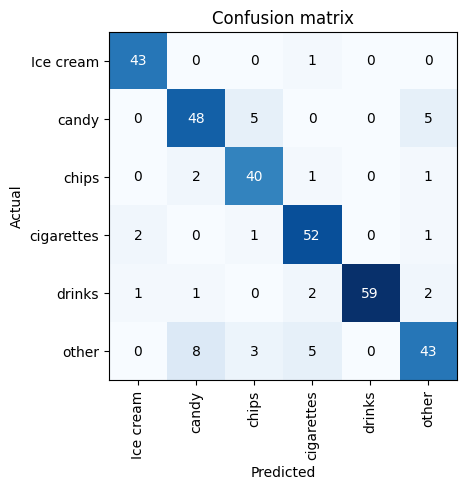

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Selecting the best model

So far we have used resnet18. This is a simple architecture that is best for prototyping. There are better models. I will use a library called "timm" (PyTorch image models), a library by Ross Wightman which contains the best state-of-the-art computer vision models ready for transfer learning.

In [1]:
from fastai.vision.all import *
import shutil
from pathlib import Path
import zipfile

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# The data is in a different file in Google drive:
!pip install gdown -Uqq
!gdown 1W44htjbuw-IRcgs_WsgDViRBSbAm38rk

Downloading...
From (uriginal): https://drive.google.com/uc?id=1W44htjbuw-IRcgs_WsgDViRBSbAm38rk
From (redirected): https://drive.google.com/uc?id=1W44htjbuw-IRcgs_WsgDViRBSbAm38rk&confirm=t&uuid=8b72a8d4-918a-4cb3-b070-c5757771fa97
To: /kaggle/working/cstore_images.zip
100%|█████████████████████████████████████████| 229M/229M [00:02<00:00, 111MB/s]


In [3]:
with zipfile.ZipFile('/kaggle/working/cstore_images.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working')

In [4]:
# create our path object
path = Path('cstore_images')

#view the labels
path.ls()

(#7) [Path('cstore_images/drinks'),Path('cstore_images/candy'),Path('cstore_images/Ice cream'),Path('cstore_images/cigarettes'),Path('cstore_images/other'),Path('cstore_images/.DS_Store'),Path('cstore_images/chips')]

In [5]:
Path('cstore_images/.DS_Store').unlink()

In [8]:
chk_cats()

{'candy': 284, 'chips': 255, 'cigarettes': 267, 'drinks': 273, 'Ice cream': 279, 'other': 284} 1642


In [6]:
cstore = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.3))

In [39]:
dls = cstore.dataloaders(path)

In [12]:
! git clone --depth 1 https://github.com/rwightman/pytorch-image-models.git
%cd pytorch-image-models/results

Cloning into 'pytorch-image-models'...
remote: Enumerating objects: 568, done.
remote: Counting objects: 100% (568/568), done.
remote: Compressing objects: 100% (411/411), done.
remote: Total 568 (delta 220), reused 349 (delta 151), pack-reused 0
Receiving objects: 100% (568/568), 2.49 MiB | 4.75 MiB/s, done.
Resolving deltas: 100% (220/220), done.
/kaggle/working/pytorch-image-models/results


In [14]:
#use pandas to read the csv
import pandas as pd
df_results = pd.read_csv('results-imagenet.csv')

In [15]:
df_results['model_org'] = df_results['model'] 
df_results['model'] = df_results['model'].str.split('.').str[0]

In [16]:
def get_data(part, col):
    df = pd.read_csv(f'benchmark-{part}-amp-nhwc-pt111-cu113-rtx3090.csv').merge(df_results, on='model')
    df['secs'] = 1. / df[col]
    df['family'] = df.model.str.extract('^([a-z]+?(?:v2)?)(?:\d|_|$)')
    df = df[~df.model.str.endswith('gn')]
    df.loc[df.model.str.contains('in22'),'family'] = df.loc[df.model.str.contains('in22'),'family'] + '_in22'
    df.loc[df.model.str.contains('resnet.*d'),'family'] = df.loc[df.model.str.contains('resnet.*d'),'family'] + 'd'
    return df[df.family.str.contains('^re[sg]netd?|beit|convnext|levit|efficient|vit|vgg|swin')]

In [17]:
df = get_data('infer', 'infer_samples_per_sec')

In [18]:
import plotly.express as px
w,h = 1000,800

def show_all(df, title, size):
    return px.scatter(df, width=w, height=h, size=df[size]**2, title=title,
        x='secs',  y='top1', log_x=True, color='family', hover_name='model_org', hover_data=[size])

In [19]:
show_all(df, 'Inference', 'infer_img_size')

### A comparison of computer vision models
The top models can be inferred from this plot. "Convnext" models are very popular and offer a great trade off between inference time and performance, so we will try one of these models on our data. 

In [31]:
!pip3 install timm -Uqq

In [32]:
import timm
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tiny']

In [33]:
learn = vision_learner(dls, 'convnext_tiny', metrics=[accuracy, F1Score(average='weighted'), Precision(average='weighted'), Recall(average='weighted')])
learn.fine_tune(4)

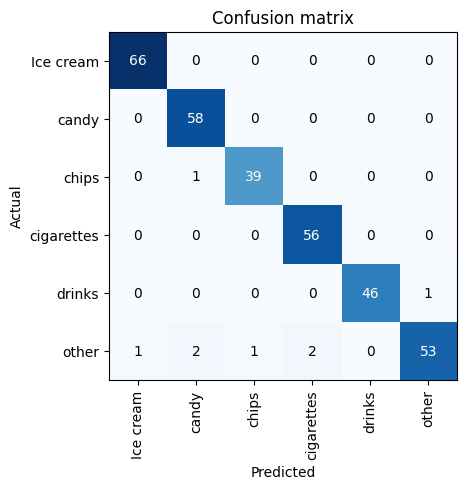

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Interpreting top losses
Fastai provides a method within it's <code>ClassificationInterpretation</code> class called <code>plot_top_losses</code> that we can use to view the items with the highest loss values. Note that the term "loss" is what the model tries to minimize using stochastic gradient descent. This is in contrast to a "metric," which is a number given for human interpretation of the model. Here, we can see that the model was most confused with prepaid cards, where it was 100% certain to classify as cigarettes. It also misclassified a picture of "other" as "drinks", but we can see that there were in fact drinks of beer in the photo. So the model did not do a bad job necessarily here. In the third photo, bags of beef jerky are hanging from shelves, but the image also contains candy, and the model did in fact have candy in the photo. The model also misclassified "utz potato chips" as "candy".  

We could go on and try to improve the model, but this would involve going back to stage 1, data acquisition. There simply weren't enough examples of prepaid cards and utz potato chips for the model to learn from. If this were a real business problem with stakeholers involved, we could share these results and get some feedback. However, due to time constraints (also a real-world problem) we end our analysis here, satisfied with an accuracy of 97.5%.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



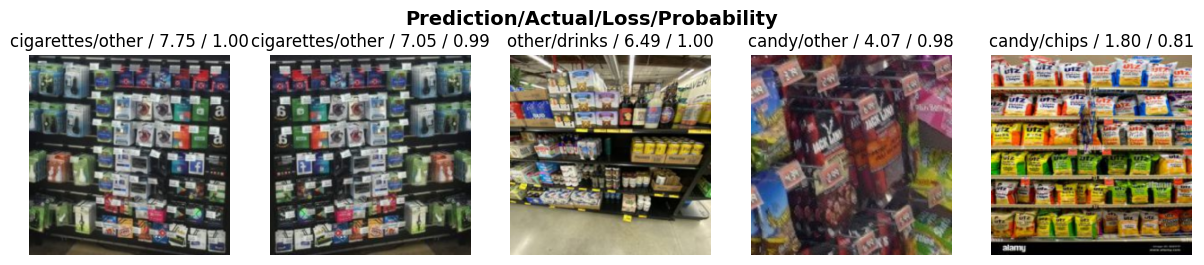

In [35]:
interp.plot_top_losses(5, nrows=1)

In [36]:
timm.list_models('beit*')

['beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224']

In [15]:
learn = vision_learner(dls, 'beit_large_patch16_224', metrics=[accuracy, F1Score(average='weighted'), Precision(average='weighted'), Recall(average='weighted')])
learn.fine_tune(4)

OutOfMemoryError: Exception occured in `TrainEvalCallback` when calling event `before_fit`:
	CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 15.90 GiB total capacity; 14.81 GiB already allocated; 21.75 MiB free; 14.92 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [7]:
dls = cstore.dataloaders(path, bs=32)

In [21]:
torch.cuda.empty_cache()

In [8]:
learn = vision_learner(dls, 'beit_base_patch16_224', metrics=[accuracy, F1Score(average='weighted'), Precision(average='weighted'), Recall(average='weighted')])
learn.fine_tune(4)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
